In [1]:
import pandas as pd
import numpy as np
import os
import json
import ast
import collections, operator, functools

In [2]:
per_ball_data = pd.read_csv('../data/saved_data/all_matches.csv')
per_ball_data.head(5)

,game_id,date,venue,location,gender,match_type,innings,batting_team,bowling_team,batting_team_players,...,is_wicket,wicket_type,fielder,player_out,target_runs,target_overs,current_runs,current_wickets,powerplay,extras_details
0,52dd3775-63e5-4e33-acdf-93b764a94cf0,2023-03-26,"SuperSport Park, Centurion",Centurion,male,T20,1,West Indies,South Africa,"['7fca84b7', '73c18486', '09a9d073', '3241e3fd...",...,False,NaN,NaN,NaN,NaN,NaN,1,0,True,NaN
1,52dd3775-63e5-4e33-acdf-93b764a94cf0,2023-03-26,"SuperSport Park, Centurion",Centurion,male,T20,1,West Indies,South Africa,"['7fca84b7', '73c18486', '09a9d073', '3241e3fd...",...,False,NaN,NaN,NaN,NaN,NaN,2,0,True,NaN
2,52dd3775-63e5-4e33-acdf-93b764a94cf0,2023-03-26,"SuperSport Park, Centurion",Centurion,male,T20,1,West Indies,South Africa,"['7fca84b7', '73c18486', '09a9d073', '3241e3fd...",...,True,caught,b8cc58c9,7fca84b7,NaN,NaN,2,1,True,NaN
3,52dd3775-63e5-4e33-acdf-93b764a94cf0,2023-03-26,"SuperSport Park, Centurion",Centurion,male,T20,1,West Indies,South Africa,"['7fca84b7', '73c18486', '09a9d073', '3241e3fd...",...,False,NaN,NaN,NaN,NaN,NaN,2,1,True,NaN
4,52dd3775-63e5-4e33-acdf-93b764a94cf0,2023-03-26,"SuperSport Park, Centurion",Centurion,male,T20,1,West Indies,South Africa,"['7fca84b7', '73c18486', '09a9d073', '3241e3fd...",...,False,NaN,NaN,NaN,NaN,NaN,6,1,True,NaN


In [3]:
per_ball_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857199 entries, 0 to 857198
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   game_id               857199 non-null  object 
 1   date                  857199 non-null  object 
 2   venue                 857199 non-null  object 
 3   location              816895 non-null  object 
 4   gender                857199 non-null  object 
 5   match_type            857199 non-null  object 
 6   innings               857199 non-null  int64  
 7   batting_team          857199 non-null  object 
 8   bowling_team          857199 non-null  object 
 9   batting_team_players  857199 non-null  object 
 10  bowling_team_players  857199 non-null  object 
 11  over                  857199 non-null  int64  
 12  ball_in_over          857199 non-null  int64  
 13  batter                857199 non-null  object 
 14  bowler                857199 non-null  object 
 15  

---
# Per player statistics: Bowlers

We want to rate the bowlers based on their performances.
On average:
- How many wickets does each bowler take per ball?
- How many runs does each bowler give up per ball?
- How many bowler-related extras does each bowler give up per ball?

In [4]:
per_ball_data['wicket_type'].value_counts()

wicket_type
caught                   23990
bowled                   10881
run out                   4792
lbw                       4101
stumped                   1938
caught and bowled         1588
retired hurt                61
hit wicket                  38
retired out                 12
obstructing the field        7
retired not out              7
hit the ball twice           1
Name: count, dtype: int64

In [5]:
# We'll need to parse extras details as a string so we can analyse them better.
def parse_extras_details(extras_details):
    if pd.isna(extras_details):
        return {}
    try:
        return ast.literal_eval(extras_details)
    except:
        return {}
per_ball_data['extras_details'] = per_ball_data['extras_details'].apply(parse_extras_details)

In [6]:
per_ball_data['extras_details'].dtype

dtype('O')

In [7]:
extras_details = per_ball_data[per_ball_data['extras_details'] != {}]['extras_details']

def sum_dict_series(series):
    # Apply Counter to each dictionary and reduce
    result = dict(functools.reduce(operator.add,
                                 map(collections.Counter, series)))
    return result

extras_counts = sum_dict_series(extras_details)
extras_counts


{'wides': 43517,
 'legbyes': 13741,
 'noballs': 4728,
 'byes': 6511,
 'penalty': 70}

In [8]:
dicts_to_add = [{'a': 1, 'b': 2}, {'a': 3, 'c': 4}]
total_counts = {}
for extras_dict in dicts_to_add:
    total_counts = {**total_counts, **extras_dict}
total_counts

{'a': 3, 'b': 2, 'c': 4}

In [9]:
bowlers_df = per_ball_data[['game_id', 'bowler', 'runs_batter', 'extras', 'total', 'is_wicket', 'wicket_type', 'extras_details', 'powerplay']].copy()
bowlers_df.head(5)

,game_id,bowler,runs_batter,extras,total,is_wicket,wicket_type,extras_details,powerplay
0,52dd3775-63e5-4e33-acdf-93b764a94cf0,3a60e0b5,1,0,1,False,NaN,{},True
1,52dd3775-63e5-4e33-acdf-93b764a94cf0,3a60e0b5,1,0,1,False,NaN,{},True
2,52dd3775-63e5-4e33-acdf-93b764a94cf0,3a60e0b5,0,0,0,True,caught,{},True
3,52dd3775-63e5-4e33-acdf-93b764a94cf0,3a60e0b5,0,0,0,False,NaN,{},True
4,52dd3775-63e5-4e33-acdf-93b764a94cf0,3a60e0b5,4,0,4,False,NaN,{},True


In [10]:
def get_bowler_statistics(per_ball_data):
    bowlers_df = per_ball_data[['game_id', 'bowler', 'runs_batter', 'extras', 'total', 'is_wicket', 'wicket_type', 'extras_details', 'powerplay']].copy()
    # Relevant wickets
    relevant_wicket_types = ['bowled', 'lbw', 'caught', 'caught and bowled', 'stumped']
    bowlers_df['relevant_wicket'] = bowlers_df['wicket_type'].isin(relevant_wicket_types)
    # Relevant extras
    relevant_extras_types = ['noballs', 'wides']
    bowlers_df['runs_from_relevant_extras'] = bowlers_df['extras_details'].apply(lambda x: sum(x.get(key, 0) for key in relevant_extras_types))
    
    powerplay_df = bowlers_df[bowlers_df['powerplay'] == True]
    non_powerplay_df = bowlers_df[bowlers_df['powerplay'] == False]

    total_stats = bowlers_df.groupby('bowler').agg({
        'runs_batter': ['mean'],
        'runs_from_relevant_extras': ['mean'],
        'total': ['mean'],
        'relevant_wicket': ['mean']
    }).rename(columns={'runs_batter': 'batter_runs_conceded', 'total': 'total_runs_conceded', 'relevant_wicket': 'taken_from_relevant_wickets'})

    powerplay_stats = powerplay_df.groupby('bowler').agg({
        'runs_batter': ['mean'],
        'runs_from_relevant_extras': ['mean'],
        'total': ['mean'],
        'relevant_wicket': ['mean']
    }).rename(columns={'runs_batter': 'batter_runs_conceded', 'total': 'total_runs_conceded', 'relevant_wicket': 'taken_from_relevant_wickets'})

    non_powerplay_stats = non_powerplay_df.groupby('bowler').agg({
        'runs_batter': ['mean'],
        'runs_from_relevant_extras': ['mean'],
        'total': ['mean'],
        'relevant_wicket': ['mean']
    }).rename(columns={'runs_batter': 'batter_runs_conceded', 'total': 'total_runs_conceded', 'relevant_wicket': 'taken_from_relevant_wickets'}) 

    # Rename columns to be more descriptive and add prefixes for each stat type
    total_stats.columns = [
        f'total_{col[0]}_{col[1]}' for col in total_stats.columns
    ]
    powerplay_stats.columns = [
        f'powerplay_{col[0]}_{col[1]}' for col in powerplay_stats.columns
    ]
    non_powerplay_stats.columns = [
        f'non_powerplay_{col[0]}_{col[1]}' for col in non_powerplay_stats.columns
    ]

    # Merge all stats together
    bowler_stats = pd.concat([
        total_stats,
        powerplay_stats,
        non_powerplay_stats
    ], axis=1)
    return bowler_stats
bowler_stats = get_bowler_statistics(per_ball_data)
bowler_stats.head(5)

,total_batter_runs_conceded_mean,total_runs_from_relevant_extras_mean,total_total_runs_conceded_mean,total_taken_from_relevant_wickets_mean,powerplay_batter_runs_conceded_mean,powerplay_runs_from_relevant_extras_mean,powerplay_total_runs_conceded_mean,powerplay_taken_from_relevant_wickets_mean,non_powerplay_batter_runs_conceded_mean,non_powerplay_runs_from_relevant_extras_mean,non_powerplay_total_runs_conceded_mean,non_powerplay_taken_from_relevant_wickets_mean
bowler,,,,,,,,,,,,
00029c30,1.090909,0.060606,1.151515,0.045455,NaN,NaN,NaN,NaN,1.090909,0.060606,1.151515,0.045455
00321fff,1.067210,0.036660,1.107943,0.052953,NaN,NaN,NaN,NaN,1.067210,0.036660,1.107943,0.052953
00467a76,1.236742,0.068182,1.348485,0.066288,1.331034,0.048276,1.427586,0.055172,1.201044,0.075718,1.318538,0.070496
005f0561,0.864734,0.021739,0.898551,0.057971,0.757396,0.017751,0.775148,0.041420,0.938776,0.024490,0.983673,0.069388
007113d7,1.008584,0.025751,1.068670,0.081545,NaN,NaN,NaN,NaN,1.008584,0.025751,1.068670,0.081545


In [34]:
bowler_stats.reset_index().to_csv('../data/saved_data/bowler_stats.csv', index=False)


---
# Per player statistics: Batsmen

We want to rate the batsmen based on their performances.
On average:
- How many runs do they score per ball?
- How many high-scoring hits do they make per ball (4 or more runs)? (using as don't have boundaries data)
    - For runs/high-scoring hits, we'll separate powerplay, and non-powerplay, as well as total.
- How often are they gotten out?

In [11]:
batsmen_df = per_ball_data[['game_id', 'batter', 'runs_batter', 'extras', 'total', 'is_wicket', 'powerplay']].copy()

In [12]:
def get_batsman_statistics(per_ball_data):
    batsmen_df = per_ball_data[['game_id', 'batter', 'runs_batter', 'extras', 'total', 'is_wicket', 'powerplay']].copy()
    batsmen_df['high_scoring_hit'] = batsmen_df['runs_batter'] >= 4

    powerplay_df = batsmen_df[batsmen_df['powerplay'] == True]
    non_powerplay_df = batsmen_df[batsmen_df['powerplay'] == False]

    total_stats = batsmen_df.groupby('batter').agg({
        'runs_batter': ['mean'],
        'high_scoring_hit': ['mean'],
        'total': ['mean'],
        'is_wicket': ['mean']
    })

    powerplay_stats = powerplay_df.groupby('batter').agg({
        'runs_batter': ['mean'],
        'high_scoring_hit': ['mean'],
        'total': ['mean'],
        'is_wicket': ['mean']
    })

    non_powerplay_stats = non_powerplay_df.groupby('batter').agg({
        'runs_batter': ['mean'],
        'high_scoring_hit': ['mean'],
        'total': ['mean'],
        'is_wicket': ['mean']
    })

    # Rename columns to be more descriptive and add prefixes for each stat type
    total_stats.columns = [
        f'total_{col[0]}_{col[1]}' for col in total_stats.columns
    ]
    powerplay_stats.columns = [
        f'powerplay_{col[0]}_{col[1]}' for col in powerplay_stats.columns
    ]
    non_powerplay_stats.columns = [
        f'non_powerplay_{col[0]}_{col[1]}' for col in non_powerplay_stats.columns
    ]

    # Merge all stats together
    batsman_stats = pd.concat([
        total_stats,
        powerplay_stats,
        non_powerplay_stats
    ], axis=1)

    return batsman_stats
batsman_stats = get_batsman_statistics(per_ball_data)
batsman_stats.head(5)

,total_runs_batter_mean,total_high_scoring_hit_mean,total_total_mean,total_is_wicket_mean,powerplay_runs_batter_mean,powerplay_high_scoring_hit_mean,powerplay_total_mean,powerplay_is_wicket_mean,non_powerplay_runs_batter_mean,non_powerplay_high_scoring_hit_mean,non_powerplay_total_mean,non_powerplay_is_wicket_mean
batter,,,,,,,,,,,,
00015688,0.294118,0.029412,0.485294,0.044118,0.375,0.05,0.525,0.025,0.178571,0.000000,0.428571,0.071429
00029c30,0.454545,0.000000,0.818182,0.000000,NaN,NaN,NaN,NaN,0.454545,0.000000,0.818182,0.000000
0030a57d,0.533333,0.000000,0.733333,0.000000,NaN,NaN,NaN,NaN,0.533333,0.000000,0.733333,0.000000
00321fff,0.612245,0.040816,0.673469,0.081633,NaN,NaN,NaN,NaN,0.612245,0.040816,0.673469,0.081633
00467a76,0.974684,0.101266,1.088608,0.101266,NaN,NaN,NaN,NaN,0.974684,0.101266,1.088608,0.101266


In [33]:
batsman_stats.reset_index().to_csv('../data/saved_data/batter_stats.csv', index=False)

Looks like we have some nan values in the stats. This should be all good though, it suggests that they have not batted in powerplays etc...
Will keep as is, they shouldn't be counted in the per-team stats and therefore we don't want to replace with 0.

Now for merging back onto the original dataframe.

---


In [13]:
per_game_data = per_ball_data[['game_id', 'innings', 'bowler', 'batter', 'current_runs', 'current_wickets']].copy()
per_game_data = per_game_data.merge(bowler_stats, on=['bowler'], how='left') \
                             .merge(batsman_stats, on=['batter'], how='left')
per_game_data.head(3)

,game_id,innings,bowler,batter,current_runs,current_wickets,total_batter_runs_conceded_mean,total_runs_from_relevant_extras_mean,total_total_runs_conceded_mean,total_taken_from_relevant_wickets_mean,...,total_total_mean,total_is_wicket_mean,powerplay_runs_batter_mean,powerplay_high_scoring_hit_mean,powerplay_total_mean,powerplay_is_wicket_mean,non_powerplay_runs_batter_mean,non_powerplay_high_scoring_hit_mean,non_powerplay_total_mean,non_powerplay_is_wicket_mean
0,52dd3775-63e5-4e33-acdf-93b764a94cf0,1,3a60e0b5,7fca84b7,1,0,1.27909,0.044619,1.345582,0.051619,...,1.381425,0.045086,1.387970,0.237594,1.460150,0.042105,1.222973,0.146396,1.263514,0.049550
1,52dd3775-63e5-4e33-acdf-93b764a94cf0,1,3a60e0b5,73c18486,2,0,1.27909,0.044619,1.345582,0.051619,...,1.410211,0.061620,1.307902,0.220708,1.376022,0.054496,1.402985,0.189055,1.472637,0.074627
2,52dd3775-63e5-4e33-acdf-93b764a94cf0,1,3a60e0b5,7fca84b7,2,1,1.27909,0.044619,1.345582,0.051619,...,1.381425,0.045086,1.387970,0.237594,1.460150,0.042105,1.222973,0.146396,1.263514,0.049550


In [14]:
per_game_data.columns

Index(['game_id', 'innings', 'bowler', 'batter', 'current_runs',
       'current_wickets', 'total_batter_runs_conceded_mean',
       'total_runs_from_relevant_extras_mean',
       'total_total_runs_conceded_mean',
       'total_taken_from_relevant_wickets_mean',
       'powerplay_batter_runs_conceded_mean',
       'powerplay_runs_from_relevant_extras_mean',
       'powerplay_total_runs_conceded_mean',
       'powerplay_taken_from_relevant_wickets_mean',
       'non_powerplay_batter_runs_conceded_mean',
       'non_powerplay_runs_from_relevant_extras_mean',
       'non_powerplay_total_runs_conceded_mean',
       'non_powerplay_taken_from_relevant_wickets_mean',
       'total_runs_batter_mean', 'total_high_scoring_hit_mean',
       'total_total_mean', 'total_is_wicket_mean',
       'powerplay_runs_batter_mean', 'powerplay_high_scoring_hit_mean',
       'powerplay_total_mean', 'powerplay_is_wicket_mean',
       'non_powerplay_runs_batter_mean', 'non_powerplay_high_scoring_hit_mean',
     

In [24]:
per_game_aggregated = per_game_data.groupby(['game_id', 'innings']).agg({ # will effectively calculate weighted averages of bowler and batsman stats depending on no. of balls
    **{column: 'mean' for column in per_game_data.columns if column not in ['game_id', 'innings', 'bowler', 'batter', 'current_runs', 'current_wickets']},
    'current_runs': 'max',
    'current_wickets': 'max'
}).rename(columns={'current_runs': 'final_runs', 'current_wickets': 'final_wickets'})
per_game_aggregated.head(5)

total_batter_runs_conceded_mean  \
game_id                              innings                                    
002241a4-33c2-4760-98f5-2e948c8ba72d 1                               1.184652   
                                     2                               1.030764   
005ad76d-5118-42b3-b201-7a66ddd993ff 1                               1.078685   
                                     2                               1.062712   
0061255e-76ea-4415-aa89-fb6e87c61186 1                               1.372746   

                                              total_runs_from_relevant_extras_mean  \
game_id                              innings                                         
002241a4-33c2-4760-98f5-2e948c8ba72d 1                                    0.051242   
                                     2                                    0.039624   
005ad76d-5118-42b3-b201-7a66ddd993ff 1                                    0.050171   
                                     2                                    0.037054   
0061255e-76ea-4415-aa89-fb6e87c61186 1                                    0.049367   

                                              total_total_runs_conceded_mean  \
game_id                              innings                                   
002241a4-33c2-4760-98f5-2e948c8ba72d 1                              1.245997   
                                     2                              1.104386   
005ad76d-5118-42b3-b201-7a66ddd993ff 1                              1.148466   
                                     2                              1.137472   
0061255e-76ea-4415-aa89-fb6e87c61186 1                              1.444206   

                                              total_taken_from_relevant_wickets_mean  \
game_id                              innings                                           
002241a4-33c2-4760-98f5-2e948c8ba72d 1                                      0.055723   
                                     2                                      0.046078   
005ad76d-5118-42b3-b201-7a66ddd993ff 1                                      0.053412   
                                     2                                      0.053341   
0061255e-76ea-4415-aa89-fb6e87c61186 1                                      0.053401   

                                              powerplay_batter_runs_conceded_mean  \
game_id                              innings                                        
002241a4-33c2-4760-98f5-2e948c8ba72d 1                                   1.374270   
                                     2                                   1.075103   
005ad76d-5118-42b3-b201-7a66ddd993ff 1                                   1.033373   
                                     2                                   1.031813   
0061255e-76ea-4415-aa89-fb6e87c61186 1                                   1.295026   

                                              powerplay_runs_from_relevant_extras_mean  \
game_id                              innings                                             
002241a4-33c2-4760-98f5-2e948c8ba72d 1                                        0.094265   
                                     2                                        0.032575   
005ad76d-5118-42b3-b201-7a66ddd993ff 1                                        0.054930   
                                     2                                        0.057145   
0061255e-76ea-4415-aa89-fb6e87c61186 1                                        0.052117   

                                              powerplay_total_runs_conceded_mean  \
game_id                              innings                                       
002241a4-33c2-4760-98f5-2e948c8ba72d 1                                  1.471532   
                                     2                                  1.139223   
005ad76d-5118-42b3-b201-7a66ddd993ff 1                                  1.107867   
                                     2            

In [25]:
per_game_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7533 entries, ('002241a4-33c2-4760-98f5-2e948c8ba72d', np.int64(1)) to ('fffbd489-b64b-4817-a6fd-f85644d37207', np.int64(2))
Data columns (total 26 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   total_batter_runs_conceded_mean                 7533 non-null   float64
 1   total_runs_from_relevant_extras_mean            7533 non-null   float64
 2   total_total_runs_conceded_mean                  7533 non-null   float64
 3   total_taken_from_relevant_wickets_mean          7533 non-null   float64
 4   powerplay_batter_runs_conceded_mean             7533 non-null   float64
 5   powerplay_runs_from_relevant_extras_mean        7533 non-null   float64
 6   powerplay_total_runs_conceded_mean              7533 non-null   float64
 7   powerplay_taken_from_relevant_wickets_mean      7533 non-null   float64
 8   non_powerplay_bat

In [28]:
# Standardize all columns to have mean 0 and standard deviation 1
standardized = (per_game_aggregated - per_game_aggregated.mean()) / per_game_aggregated.std()
standardized = standardized.drop(columns=['final_runs', 'final_wickets']).merge(per_game_aggregated.reset_index()[['game_id', 'innings', 'final_runs', 'final_wickets']], on=['game_id', 'innings'], how='left')
standardized.head(5)


,game_id,innings,total_batter_runs_conceded_mean,total_runs_from_relevant_extras_mean,total_total_runs_conceded_mean,total_taken_from_relevant_wickets_mean,powerplay_batter_runs_conceded_mean,powerplay_runs_from_relevant_extras_mean,powerplay_total_runs_conceded_mean,powerplay_taken_from_relevant_wickets_mean,...,powerplay_runs_batter_mean,powerplay_high_scoring_hit_mean,powerplay_total_mean,powerplay_is_wicket_mean,non_powerplay_runs_batter_mean,non_powerplay_high_scoring_hit_mean,non_powerplay_total_mean,non_powerplay_is_wicket_mean,final_runs,final_wickets
0,002241a4-33c2-4760-98f5-2e948c8ba72d,1,0.822497,-0.152112,0.750288,0.725801,1.714255,0.786943,1.806211,-0.443284,...,-0.067017,0.048304,-0.176614,0.319407,0.636517,0.408743,0.603931,-0.444931,199,5
1,002241a4-33c2-4760-98f5-2e948c8ba72d,2,0.057194,-0.494480,0.025546,-0.414094,0.393297,-0.696873,0.311807,-0.866606,...,0.083423,-0.139888,-0.095311,-1.294053,0.839044,0.709896,0.757129,-0.090809,97,7
2,005ad76d-5118-42b3-b201-7a66ddd993ff,1,0.295511,-0.183686,0.251142,0.452743,0.209040,-0.159175,0.170795,2.076613,...,0.713710,0.908928,0.697545,-0.376023,0.303475,0.466266,0.345178,-0.174936,173,6
3,005ad76d-5118-42b3-b201-7a66ddd993ff,2,0.216071,-0.570194,0.194874,0.444315,0.202152,-0.105897,0.207373,0.036535,...,1.073143,1.151856,1.065811,0.062678,0.660881,0.726828,0.675743,0.055117,167,7
4,0061255e-76ea-4415-aa89-fb6e87c61186,1,1.757912,-0.207368,1.764689,0.451444,1.364354,-0.226842,1.389270,-0.220704,...,0.956534,1.018972,0.949863,-0.251526,1.408916,1.649570,1.466700,-0.347873,234,6


In [29]:
standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7533 entries, 0 to 7532
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   game_id                                         7533 non-null   object 
 1   innings                                         7533 non-null   int64  
 2   total_batter_runs_conceded_mean                 7533 non-null   float64
 3   total_runs_from_relevant_extras_mean            7533 non-null   float64
 4   total_total_runs_conceded_mean                  7533 non-null   float64
 5   total_taken_from_relevant_wickets_mean          7533 non-null   float64
 6   powerplay_batter_runs_conceded_mean             7533 non-null   float64
 7   powerplay_runs_from_relevant_extras_mean        7533 non-null   float64
 8   powerplay_total_runs_conceded_mean              7533 non-null   float64
 9   powerplay_taken_from_relevant_wickets_mea

In [30]:
standardized.to_csv('../data/saved_data/standardized_per_game_data.csv', index=False)

---
# Possibly a glaring issue:
So I woke up this morning and realised one key thing. Each player is being rated on their performances over their entire career, not just up until the current game. 

I don't know how big an issue this is, but it's definitely notable - if it is a player's first game, they're being rated on their t20 career past that point. I belive this issue is known as 'data leakage', and I should probably instead look at player's games up to the current game instead of for their entire career, especially since the dataset spans several decades.

I think that even if it hurts the performance of the model, it's a more accurate representation of the players' abilities and therefore a better way to do predictions - it would allow us to predict games better in the future as well.

In order to implement this:
1. Get players' match data up to the current game
2. Use relevant number of games and use that to calculate stats
3. Otherwise same as before.

Impl:
- Groupby player and within that group by game.
- Calculate per_game stats for the player - easy using groupby and aggregate operations similar to above.
- Use a rolling window with the end being the current game and the size being the number of balls/games in order to calculate stats
    - May be more more challenging as window size may spill onto different players, but should be fine to work around.
    - This should hopefully be somewhat efficient using the windowed approach compared to lookup tables or going row by row.

---
# Trend analysis

Before I commit to the above, I'm going to inspect how players' stats change over time. The caveat to the above is that (from my limited knowledge of cricket) players usually only play for in t20 internationals for a few years during their primes, so this may not be a big issue.

If the general trend is that players' stats change very little over time, then I don't think it's a big issue using all of a player's data rather than just their data up to the current game, as the stats are unlikely to change much. Furthermore it's also significantly more efficient an implementation than needing to calculate previous games.

If however players' stats change a lot over time, then I should probably use historical data only.

For the sake of time, I am only going to look at batter runs and wickets taken. These are probably the most important stats and should give a good indication of what I need to know.

---

In [61]:

def perform_cusum_analysis(df, player_id, metric='runs_batter', threshold=1, check = 'bowler'):
    # Get player's chronological data
    player_data = df[df[check] == player_id] \
                            .sort_values(by='date', ascending=True)[['game_id', metric]] \
                            .groupby('game_id').agg('mean') \
                            .values \
                            .flatten()
    # Calculate mean and standard deviation
    mean = np.mean(player_data)
    std = np.std(player_data)
    
    # Initialize CUSUM arrays
    cusum_pos = np.zeros(len(player_data))
    cusum_neg = np.zeros(len(player_data))
    
    # Calculate CUSUM values
    for i in range(1, len(player_data)):
        # Standardize the observation
        z_score = (player_data[i] - mean) / std
        
        # Calculate positive and negative CUSUMs
        cusum_pos[i] = max(0, float(cusum_pos[i-1] + z_score - threshold))
        cusum_neg[i] = min(0, float(cusum_neg[i-1] + z_score + threshold))
    
    # Detect change points
    change_points = np.where(
        (abs(cusum_pos) > threshold) | 
        (abs(cusum_neg) > threshold)
    )[0]
    
    return {
        'cusum_pos': cusum_pos,
        'cusum_neg': cusum_neg,
        'change_points': change_points,
        'mean': mean,
        'std': std
    }

def analyze_performance_stability(df, metrics=['runs_batter', 'is_wicket'], check = 'bowler'):
    def categorize_trend(cusum_result):
        # If no significant changes, performance is stable
        if len(cusum_result['change_points']) == 0:
            return 'stable'
        
        # Look at direction of changes
        pos_changes = cusum_result['cusum_pos'].max() > 1
        neg_changes = cusum_result['cusum_neg'].min() < -1
        
        if pos_changes and neg_changes:
            return 'variable'  # Both improvement and decline
        elif pos_changes:
            return 'improving'
        elif neg_changes:
            return 'declining'
        return 'stable'
    
    results = {}
    for player in tqdm(df['bowler'].unique()):
        player_trends = {}
        for metric in metrics:
            cusum_result = perform_cusum_analysis(df, player, metric)
            player_trends[metric] = categorize_trend(cusum_result)
        results[player] = player_trends
    
    # Summarize results
    summary = {metric: {} for metric in metrics}
    for metric in tqdm(metrics):
        trends = [results[player][metric] for player in results]
        summary[metric] = {
            'stable': trends.count('stable') / len(trends),
            'improving': trends.count('improving') / len(trends),
            'declining': trends.count('declining') / len(trends),
            'variable': trends.count('variable') / len(trends)
        }
    
    return results, summary

# Run analysis
player_trends, trend_summary = analyze_performance_stability(per_ball_data, check='bowler')

# Print summary
print("Performance Stability Analysis: Bowlers")
for metric, stats in trend_summary.items():
    print(f"{metric}:")
    for trend, proportion in stats.items():
        print(f"{trend}: {proportion:.1%}")
    print('\n')



  1%|          | 30/3966 [00:02<04:18, 15.22it/s]/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/1978437264.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (player_data[i] - mean) / std
  3%|▎         | 114/3966 [00:07<04:08, 15.50it/s]/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/1978437264.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (player_data[i] - mean) / std
/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/1978437264.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (player_data[i] - mean) / std
  8%|▊         | 304/3966 [00:19<03:53, 15.65it/s]/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/1978437264.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (player_data[i] - mean) / std
  8%|▊         | 334/3966 [00:21<03:52, 15.61it/s]/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/

Performance Stability Analysis: Bowlers
runs_batter:
stable: 69.2%
improving: 23.7%
declining: 2.4%
variable: 4.7%


is_wicket:
stable: 70.0%
improving: 29.3%
declining: 0.5%
variable: 0.3%




In [62]:
player_trends, trend_summary = analyze_performance_stability(per_ball_data, check='batter')

# Print summary
print("Performance Stability Analysis: Batsmen")
for metric, stats in trend_summary.items():
    print(f"{metric}:")
    for trend, proportion in stats.items():
        print(f"{trend}: {proportion:.1%}")
    print('\n')

  1%|          | 30/3966 [00:01<04:10, 15.71it/s]/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/1978437264.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (player_data[i] - mean) / std
  3%|▎         | 114/3966 [00:07<04:03, 15.79it/s]/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/1978437264.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (player_data[i] - mean) / std
/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/1978437264.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (player_data[i] - mean) / std
  8%|▊         | 304/3966 [00:19<03:51, 15.81it/s]/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/1978437264.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (player_data[i] - mean) / std
  8%|▊         | 334/3966 [00:21<03:50, 15.73it/s]/var/folders/5b/kfhm4mss6sjdr7rf8618rz1w0000gq/T/ipykernel_85564/

Performance Stability Analysis: Batsmen
runs_batter:
stable: 69.2%
improving: 23.7%
declining: 2.4%
variable: 4.7%


is_wicket:
stable: 70.0%
improving: 29.3%
declining: 0.5%
variable: 0.3%




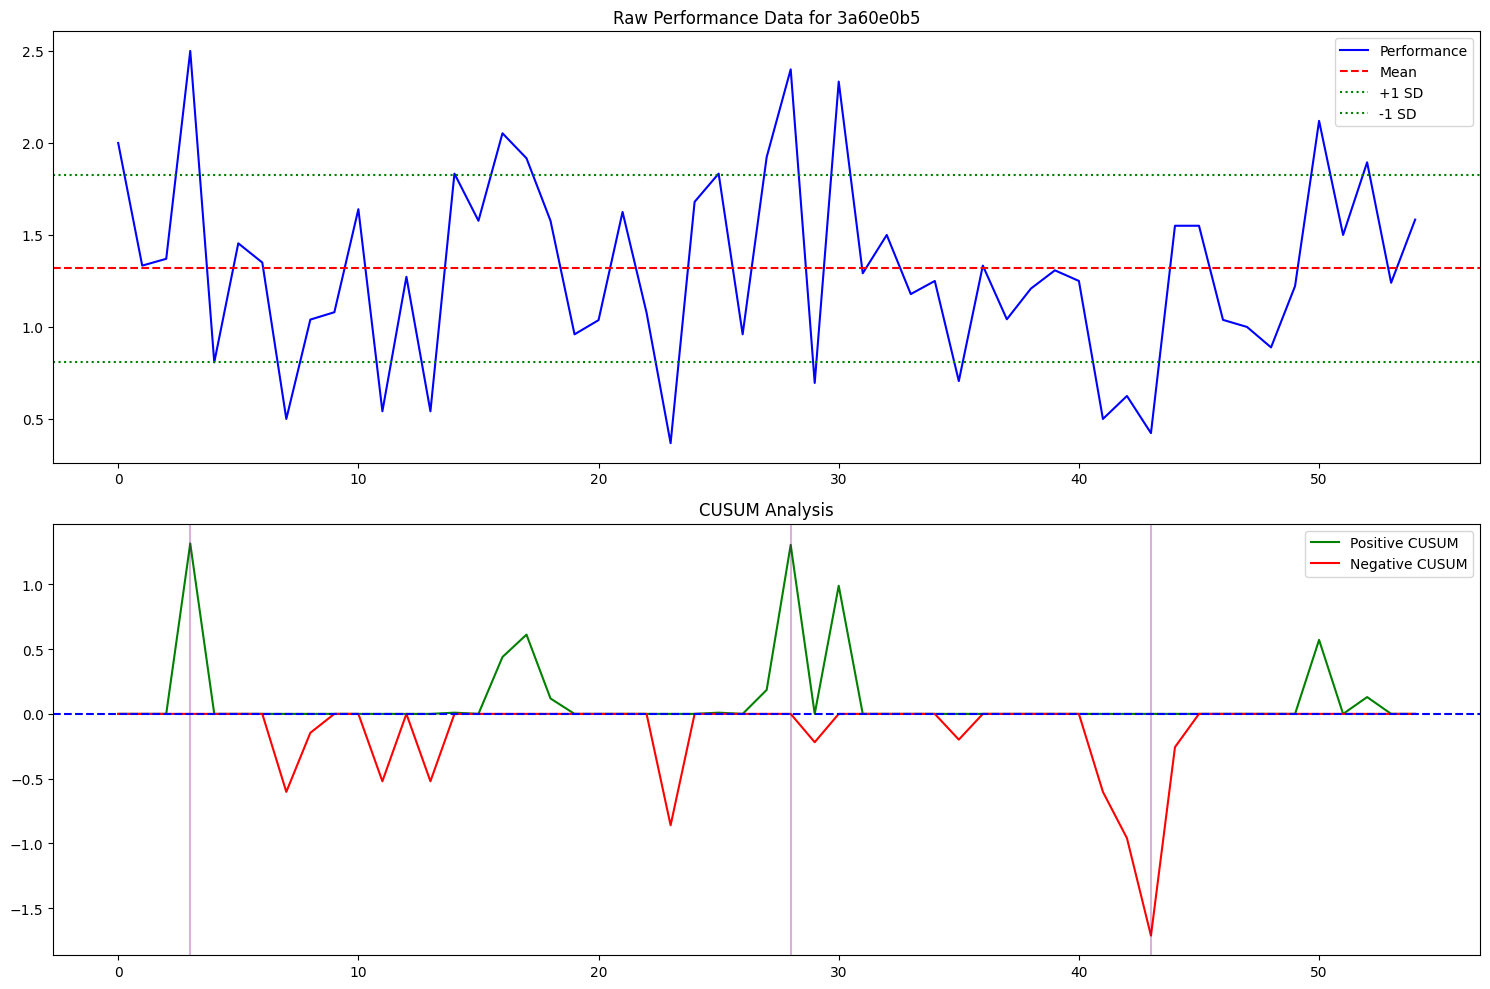


Summary:
Mean performance: 1.32
Standard deviation: 0.51
Number of change points: 3
Change points at games: [3, 28, 43]


In [59]:
def visualize_cusum_analysis(df, player_id, metric='runs_batter', threshold=1):
    import matplotlib.pyplot as plt
    
    result = perform_cusum_analysis(df, player_id, metric, threshold)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    

        # Get player's chronological data
    player_data = df[df['bowler'] == player_id] \
                            .sort_values(by='date', ascending=True)[['game_id', metric]] \
                            .groupby('game_id').agg('mean') \
                            .values \
                            .flatten()
    # Plot 1: Raw performance data
    ax1.plot(player_data, 'b-', label='Performance')
    ax1.axhline(y=result['mean'], color='r', linestyle='--', label='Mean')
    ax1.axhline(y=result['mean'] + result['std'], color='g', linestyle=':', label='+1 SD')
    ax1.axhline(y=result['mean'] - result['std'], color='g', linestyle=':', label='-1 SD')
    ax1.set_title(f'Raw Performance Data{" for " + player_id if player_id else ""}')
    ax1.legend()
    
    # Plot 2: CUSUM chart
    ax2.plot(result['cusum_pos'], 'g-', label='Positive CUSUM')
    ax2.plot(result['cusum_neg'], 'r-', label='Negative CUSUM')
    ax2.axhline(y=0, color='b', linestyle='--')
    
    # Highlight change points
    for cp in result['change_points']:
        ax2.axvline(x=cp, color='purple', alpha=0.3)
    
    ax2.set_title('CUSUM Analysis')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nSummary:")
    print(f"Mean performance: {result['mean']:.2f}")
    print(f"Standard deviation: {result['std']:.2f}")
    print(f"Number of change points: {len(result['change_points'])}")
    if len(result['change_points']) > 0:
        print(f"Change points at games: {result['change_points'].tolist()}")


visualize_cusum_analysis(per_ball_data, '3a60e0b5', 'runs_batter')

Based on these results it seems that over 2/3 of players have no significant changes in their performances over time. Furthermore, since CUSUM analysis only tracks when there is repeated improvement or decline, we can be fairly confident that blips in form of 1-2 games do not significantly affect results. Furthermore, my relatively low (arbitrarily chosen) threshold of 1sd away from the mean is fairly conservative, so there's a good chance that my results will be overestimating players' changes in form over time...

Therefore, I am going to keep my current approach of using all of a player's data in the dataset to predict results.